## Importing the requisite libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Basic details of the data

First, lets have a glimpse of the data

In [31]:
apps = pd.read_csv("./googleplaystore.csv", dtype={'Rating': np.float32})
apps.head(2)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


For the  categorical variables, how many unique categories are there?

In [32]:
apps[['App','Category','Type','Content Rating','Genres']].nunique()

App               9660
Category            34
Type                 3
Content Rating       6
Genres             120
dtype: int64

Interesting, Type column has 3 unique categories. However, we were expecting just two- Free and Paid. Whats going on there?

In [33]:
apps['Type'].value_counts()

Free    10039
Paid      800
0           1
Name: Type, dtype: int64

There is a third category-1. Lets check the details.


In [34]:
apps[apps['Type']== '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


oops! Appears that the values of the columns just got shifted one place right. Lets fix it.

In [35]:
apps.loc[10472,"App"] = "Life Made WI-Fi"
apps.loc[10472,"Category"] = "Touchscreen Photo Frame"
apps.loc[10472,"Rating"] = "1.9"
apps.loc[10472,"Reviews"] = 19
apps.loc[10472,"Size"] = "3.0M"
apps.loc[10472,"Installs"] = "1,000+"
apps.loc[10472,"Type"] = "Free"
apps.loc[10472,"Price"] = "0"
apps.loc[10472,"Content Rating"] = "Everyone"
apps.loc[10472,"Genres"] = "NaN"
apps.loc[10472,"Last Updated"] = "February 11,2018"
apps.loc[10472,"Current Ver"] = "1.0.19"
apps.loc[10472,"Android Ver"] = "4.0 and up"
apps[apps['App'] == "Life Made WI-Fi"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi,Touchscreen Photo Frame,1.9,19,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11,2018",1.0.19,4.0 and up


Now that we are done, fixing it. Lets check whether we have any duplicate rows.. that is whether the same app was scraped more than once while web scrapping.

In [36]:
apps_name = apps[['App']]#extracting in pandas dataframe not as series

duplicateapps = apps_name[apps_name.duplicated()]

print(duplicateapps['App'].nunique())



798



There appears to be 798 duplicate rows consisting of apps scrapped more than once! Lets have a close look after extracting the list of the same.We need to check whether they are different apps with the exact same name or it is truly a case of an app having being scraped more than once.

In [37]:
duplicateapps['App'].unique()[0]

'Quick PDF Scanner + OCR FREE'

In [38]:
apps[apps["App"]=="Quick PDF Scanner + OCR FREE"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
222,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
285,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80804,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up


So the same app has been scrapped more than once in the data.We can just keep the first.

In [39]:
duplicateapps['App'].value_counts().head(10)

ROBLOX                                                8
CBS Sports App - Scores, News, Stats & Watch Live     7
Duolingo: Learn Languages Free                        6
ESPN                                                  6
8 Ball Pool                                           6
Candy Crush Saga                                      6
Helix Jump                                            5
Bleacher Report: sports news, scores, & highlights    5
Bowmasters                                            5
Temple Run 2                                          5
Name: App, dtype: int64

In [40]:
#A series of all dupicates

# making a bool series 
bool_series = apps["App"].duplicated() 


unique_apps = apps[~bool_series]


print(unique_apps[unique_apps["App"]=="Quick PDF Scanner + OCR FREE"])


print(unique_apps['App'].nunique())



                              App  Category Rating Reviews  \
222  Quick PDF Scanner + OCR FREE  BUSINESS    4.2   80805   

                   Size    Installs  Type Price Content Rating    Genres  \
222  Varies with device  5,000,000+  Free     0       Everyone  Business   

          Last Updated         Current Ver   Android Ver  
222  February 26, 2018  Varies with device  4.0.3 and up  
9660


So we have detected and retained only one instance of each app in the data.We are left with 9660 unique apps. Now we are in a position to handle missing values.
First lets check how many instances are missing for the rating variable. Going forward, we will be predicting the rating, hence we require to delete any row where rating is itself missing.

We noticed that there are some float columns which have textual contents. So we require to treat the data in a format conducive to graphical representation/ model building.

In [41]:
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

unique_apps['Size'] = unique_apps['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: float(str(x).replace('k', '')) * 1024 if 'k' in str(x) else x)
unique_apps['Size'] = unique_apps['Size'].apply(lambda x: float(x))
unique_apps['Installs'] = unique_apps['Installs'].apply(lambda x : str(x).replace('+', '') if '+' in str(x) else x)
unique_apps['Installs'] = unique_apps['Installs'].apply(lambda x: str(x).replace(',', '') if ',' in str(x) else x)
unique_apps['Installs'] = unique_apps['Installs'].apply(lambda x: float(x))

unique_apps['Price'] = unique_apps['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
unique_apps['Price'] = unique_apps['Price'].apply(lambda x: float(x))

unique_apps['Reviews'] = unique_apps['Reviews'].apply(lambda x: float(x))
unique_apps['Rating'] = unique_apps['Rating'].apply(lambda x: float(x))
unique_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
App               9660 non-null object
Category          9660 non-null object
Rating            8197 non-null float64
Reviews           9660 non-null float64
Size              8433 non-null float64
Installs          9660 non-null float64
Type              9659 non-null object
Price             9660 non-null float64
Content Rating    9660 non-null object
Genres            9660 non-null object
Last Updated      9660 non-null object
Current Ver       9652 non-null object
Android Ver       9658 non-null object
dtypes: float64(5), object(8)
memory usage: 1.0+ MB


Now our data is clean, only a few missing data exists. Lets create a copy of the df and make further operations for missing data.

In [42]:
df = unique_apps.copy()

  
Lets delete the apps where there are no installs, as no installs would mean no rating or review.


In [43]:
df = df[df['Installs'] != 0]
df[df['Installs'] ==0]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


Also we noted There are many instances missing for 'Rating' Variable.Mostly, the apps might be new in the app store and hence the rating is zero. Going forward, we will be predicting the rating, hence we require to check this in further detail.

In [44]:
df[df["Rating"].isna()].head(3)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61.0,7.0,100000.0,Free,0.0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up
113,Wrinkles and rejuvenation,BEAUTY,NaN,182.0,5.7,100000.0,Free,0.0,Everyone 10+,Beauty,"September 20, 2017",8.0,3.0 and up
123,Manicure - nail design,BEAUTY,NaN,119.0,3.7,50000.0,Free,0.0,Everyone,Beauty,"July 23, 2018",1.3,4.1 and up


In [45]:
df[df['Reviews']==0]['Rating'].head(3)

478   NaN
479   NaN
621   NaN
Name: Rating, dtype: float64

Note that these apps have reviews but the rating is missing. Hwever we know that it is compulsory for a user to share a rating (number of stars) if he wants to review the app.For the apps that have both review and rating as zero we are not sure whether there should be some rating or not as an user can put on the number of stars in an app without reviewing the same. So we just delete all observations where rating is missing, as it is the target variable and we cannot impute the values here, as that will affect the prediction result.

In [46]:
df = df[~df['Rating'].isna()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8197 entries, 0 to 10840
Data columns (total 13 columns):
App               8197 non-null object
Category          8197 non-null object
Rating            8197 non-null float64
Reviews           8197 non-null float64
Size              7028 non-null float64
Installs          8197 non-null float64
Type              8197 non-null object
Price             8197 non-null float64
Content Rating    8197 non-null object
Genres            8197 non-null object
Last Updated      8197 non-null object
Current Ver       8193 non-null object
Android Ver       8195 non-null object
dtypes: float64(5), object(8)
memory usage: 896.5+ KB


In [47]:
df[df['Size'].isna()].head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639.0,NaN,5000000.0,Free,0.0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221.0,NaN,10000000.0,Free,0.0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057.0,NaN,1000000.0,Free,0.0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device


Lets fill up the missing sizes of the app using the mean size of same category.

In [48]:
df['Size'].replace('Varies with device', np.nan, inplace = True ) 
df['Size'].fillna(df.groupby('Category')['Size'].transform('mean'),inplace = True)
df[df['App']=='Floor Plan Creator']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639.0,12.766102,5000000.0,Free,0.0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up


In [49]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8197 entries, 0 to 10840
Data columns (total 13 columns):
App               8197 non-null object
Category          8197 non-null object
Rating            8197 non-null float64
Reviews           8197 non-null float64
Size              8197 non-null float64
Installs          8197 non-null float64
Type              8197 non-null object
Price             8197 non-null float64
Content Rating    8197 non-null object
Genres            8197 non-null object
Last Updated      8197 non-null object
Current Ver       8193 non-null object
Android Ver       8195 non-null object
dtypes: float64(5), object(8)
memory usage: 896.5+ KB


This is our final cleaned data, where we will apply various visualizations to understand the pattern and then apply ML algorithms to predict ratings.

In [50]:
df[['Rating','Reviews','Size','Installs','Price']].corr()

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.055087,-0.036153,0.040181,-0.021144
Reviews,0.055087,1.000000,-0.005207,0.624057,-0.007786
Size,-0.036153,-0.005207,1.000000,-0.003392,0.024787
Installs,0.040181,0.624057,-0.003392,1.000000,-0.009651
Price,-0.021144,-0.007786,0.024787,-0.009651,1.000000


In [51]:

df['Category'].value_counts().head(10)

FAMILY             1608
GAME                912
TOOLS               718
FINANCE             302
PRODUCTIVITY        301
LIFESTYLE           301
PERSONALIZATION     298
MEDICAL             290
PHOTOGRAPHY         263
BUSINESS            263
Name: Category, dtype: int64

In [52]:
df['Content Rating'].value_counts().head(10)


Everyone           6619
Teen                912
Mature 17+          357
Everyone 10+        305
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

In [53]:
df['Genres'].value_counts().head(10)

Tools              717
Entertainment      471
Education          429
Finance            302
Productivity       301
Lifestyle          300
Personalization    298
Action             292
Medical            290
Sports             266
Name: Genres, dtype: int64

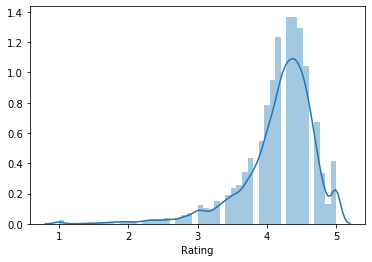

In [54]:
# sns.distplot(df.loc[df['Rating'] >= 2])
sns.distplot(df['Rating'])

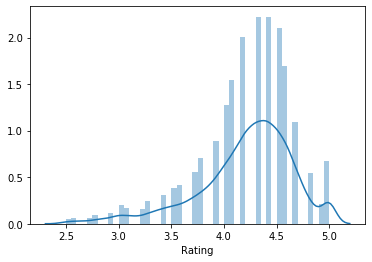

In [55]:
#reduced_df = df[df['Rating'] <= 4]
# sns.distplot(reduced_df['Rating'])
sns.distplot(df[df['Rating'] >= 2.5]['Rating'])

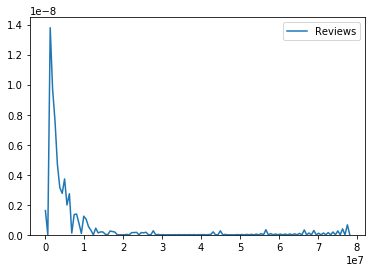

In [56]:
sns.kdeplot(df['Reviews'])

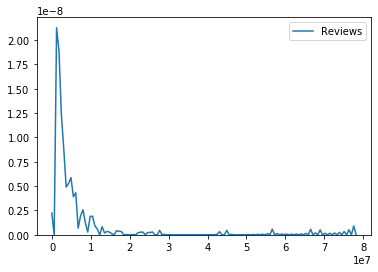

In [57]:
sns.kdeplot(df[df['Reviews'] > 1000]['Reviews'])

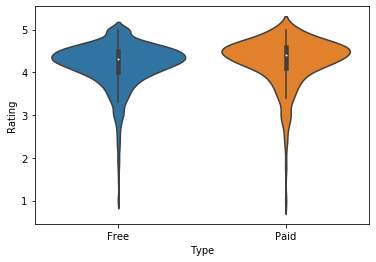

In [58]:
sns.violinplot(x = 'Type', y = 'Rating', data = df)

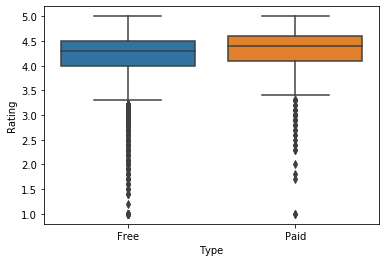

In [59]:
sns.boxplot(x = 'Type', y = 'Rating', data = df)

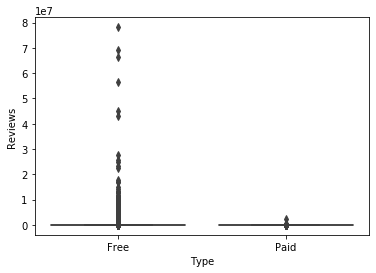

In [60]:
sns.boxplot(x = 'Type', y = 'Reviews', data = df)

In [61]:
df.groupby('Type')['Reviews'].mean()
# df.groupby('Type')['Installs'].mean()

Type
Free    274653.721191
Paid     10919.483444
Name: Reviews, dtype: float64

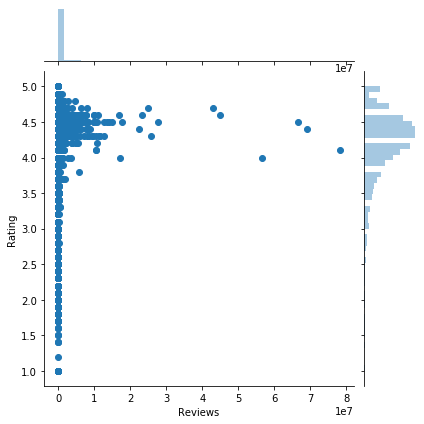

In [62]:
sns.jointplot(x = 'Reviews', y = 'Rating', data = df, kind = 'scatter')

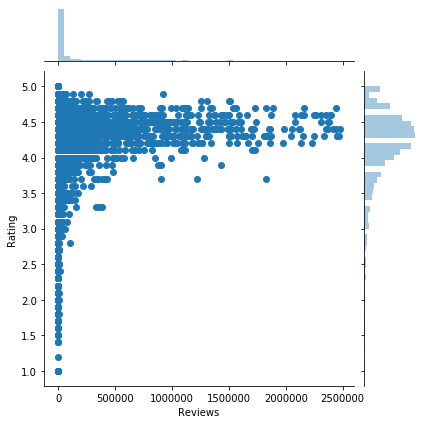

In [63]:
sns.jointplot(x = 'Reviews', y = 'Rating', data = df[df['Reviews'] < 2500000], kind = 'scatter')

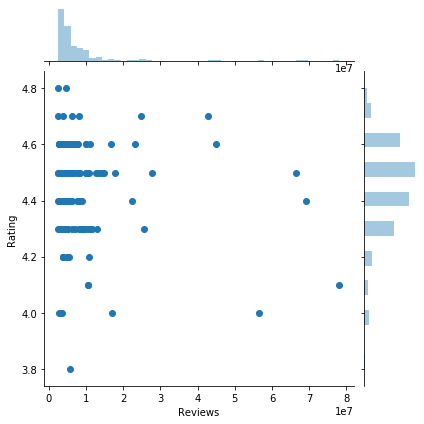

In [64]:
sns.jointplot(x = 'Reviews', y = 'Rating', data = df[df['Reviews'] > 2500000], kind = 'scatter')

In [65]:
df[df['Reviews'] > 5500000].head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847.0,55155.387234,1.000000e+09,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316.0,55155.387234,1.000000e+09,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995.0,55155.387234,1.000000e+09,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device


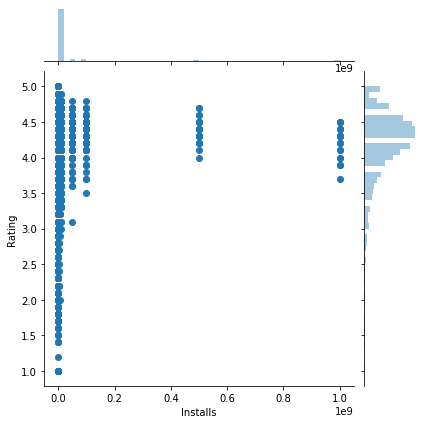

In [66]:
sns.jointplot(x = 'Installs' , y = 'Rating', data = df)

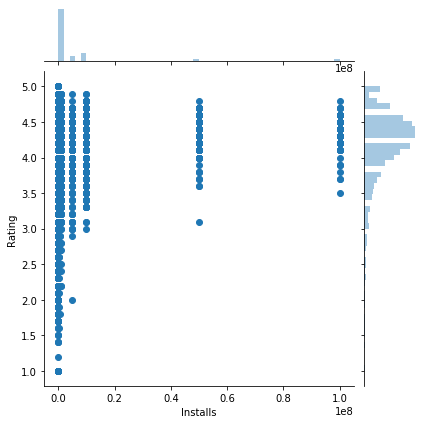

In [67]:
sns.jointplot(x = 'Installs', y = 'Rating', data = df[df['Installs'] < 200000000])

In [68]:
df[df['Type']=='Paid'].max()

App                      💎 I'm rich
Category                    WEATHER
Rating                            5
Reviews                 2.37656e+06
Size                         988160
Installs                      1e+07
Type                           Paid
Price                           400
Content Rating                 Teen
Genres                      Weather
Last Updated      September 8, 2013
dtype: object

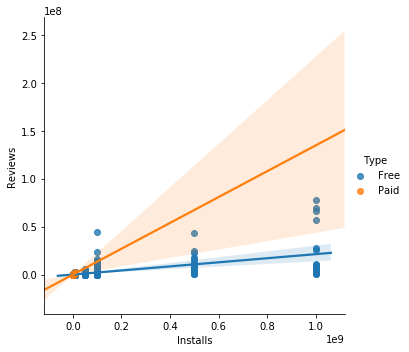

In [69]:
sns.lmplot(x = 'Installs', y = 'Reviews', data = df, hue = 'Type')

 # Category
    

In [70]:
# df['Category'].nunique
# df['Category'].unique
df['Category'].value_counts().head(10)

FAMILY             1608
GAME                912
TOOLS               718
FINANCE             302
PRODUCTIVITY        301
LIFESTYLE           301
PERSONALIZATION     298
MEDICAL             290
PHOTOGRAPHY         263
BUSINESS            263
Name: Category, dtype: int64

In [71]:
df[df["App"].str.contains("child".capitalize())]
   
    
    

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
319,Children's cartoons (Mithu-Mina-Raju),COMICS,4.6,279.0,3.300000,100000.0,Free,0.00,Everyone,Comics,"December 18, 2017",1.6,4.0 and up
2148,Masha and the Bear Child Games,FAMILY,4.1,288523.0,92.000000,10000000.0,Free,0.00,Everyone,Adventure;Education,"May 8, 2018",2.7.4,4.0 and up
2168,Children Educational Game Full,FAMILY,4.7,30.0,8023.210251,1000.0,Paid,7.49,Everyone,Educational;Education,"May 16, 2018",Varies with device,Varies with device
3596,Child Growth Tracking,PARENTING,4.4,498.0,21.579545,50000.0,Free,0.00,Everyone,Parenting,"July 25, 2018",1.5.3.1807,4.4 and up
3608,"Kids Fang - Infant Videos, Children's Songs, F...",PARENTING,4.6,349.0,4.400000,100000.0,Free,0.00,Everyone,Parenting,"March 21, 2018",1.7,4.4 and up
3617,My Child from eDziecko.pl,PARENTING,4.5,1025.0,17.000000,100000.0,Free,0.00,Everyone,Parenting,"June 29, 2018",1.3.9,4.1 and up
3624,Children's Stories 2018 - The Lion Come Lion,PARENTING,4.4,39.0,18.000000,10000.0,Free,0.00,Everyone,Parenting;Music & Video,"October 31, 2017",1.2,4.0 and up


In [72]:
df["App"].str.capitalize()

0           Photo editor & candy camera & grid & scrapbook
1                                      Coloring book moana
2        U launcher lite – free live cool themes, hide ...
3                                    Sketch - draw & paint
4                    Pixel draw - number art coloring book
                               ...                        
10834                                        Fr calculator
10836                                     Sya9a maroc - fr
10837                     Fr. mike schmitz audio teachings
10839                        The scp foundation db fr nn5n
10840        Ihoroscope - 2018 daily horoscope & astrology
Name: App, Length: 8197, dtype: object

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8197 entries, 0 to 10840
Data columns (total 13 columns):
App               8197 non-null object
Category          8197 non-null object
Rating            8197 non-null float64
Reviews           8197 non-null float64
Size              8197 non-null float64
Installs          8197 non-null float64
Type              8197 non-null object
Price             8197 non-null float64
Content Rating    8197 non-null object
Genres            8197 non-null object
Last Updated      8197 non-null object
Current Ver       8193 non-null object
Android Ver       8195 non-null object
dtypes: float64(5), object(8)
memory usage: 1.2+ MB


### Predictions ---- Lets just first take the numerical columns to predict.

Note that there is a special challenge in predicting this as the output value should be continuous and should lie between 0-5

We will not be applying linear Regression here as as linear regression cannot guarantee output within a specific range say 0-5. Also we saw there is not much correlation among the variables.

Given the method by which decision trees and Random Forest Regressor works, by averaging the Y values for the specific choices of the predictors, it is imperative that this procedure will give us required predictions and is bound to lie within the specific range.
Also KNNRegressor can be thought of another model which can be applied here for prediction purposes.


In [95]:
X = df[['Reviews', 'Size','Installs','Price']]
y = df[['Rating']]

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [106]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [107]:
y_pred = regressor.predict(X_test)

In [108]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.37298165470401307
MSE: 0.29440106837132934
RMSE: 0.5425873831663701
